# Détermination des coefficients d'association et de dissociation

#### Importation données

In [3]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint, solve_ivp
from lmfit import minimize, Parameters, report_fit, Minimizer
import matplotlib.pyplot as plt

In [4]:
d = pd.read_excel(r'\Users\camil\Documents\IMT\2A\Stage_ingénierie\Notebook\Kon_18-04-2024.xlsx')
t = d['Time points (min)'].values
dt = d['Luminescence ligne 1'].values
dt2 = d['Luminescence ligne 2'].values
dt3 = d['Luminescence ligne 3'].values
dt4 = d['Luminescence ligne 4'].values
dt5 = d['Luminescence ligne 5'].values
dt6 = d['Luminescence ligne 6'].values
dt7 = d['Luminescence ligne 7'].values
dt8 = d['Luminescence ligne 8'].values

#### Système d'équations différentielles à résoudre

In [5]:
# Fonction décrivant la cinétique de formation du complexe
def model(y, t, kon, koff):
    A, B, C = y

    dAdt = -kon * A * B + koff * C
    dBdt = -kon * A * B + koff * C
    dCdt = kon * A * B - koff * C

    return [dAdt, dBdt, dCdt]

In [6]:
# Fonction objectif à minimiser
def objective(params, t, data):
    kon = params['kon'].value
    koff = params['koff'].value

    # Concentrations initiales
    A0 = params['A0'].value
    B0 = params['B0'].value  
    alpha = params['alpha'].value
    beta = params['beta'].value

    # Conditions initiales
    y0 = [A0, B0, 0]  

    sol = odeint(model, y0, t, args=(kon, koff))
    
    solution = sol[:, 2]

    alpha_solution = alpha * solution
    model_value = alpha_solution + beta
    
    return model_value

In [7]:
def residu(params, t, data):
    try:
        model_values = objective(params, t, data)
        if np.isnan(model_values).any() or np.isinf(model_values).any():
            print("NaN ou Inf détecté dans les valeurs du modèle")
            return np.full_like(data, 1e12)  # Retourne une pénalité élevée
        
        residuals = (model_values - data).ravel()
        return residuals
    
    except Exception as e:
        print(f"Erreur dans la fonction residu : {e}")

        return np.full_like(data, 1e12)

#### Paramètres initiaux

In [8]:
params = Parameters()
params.add('alpha', value=1e3, min=0, max=1e5)
params.add('beta', value=1, min=0, max=1e2)
params.add('kon', value=1e5, min=1e3, max=1e7)  
params.add('koff', value=1e-2, min=1e-4, max=1)  
params.add('A0', value=1e-6, min=1e-9, max=1e-4)  
params.add('B0', value=2e-6, min=1e-9, max=1e-4)  

#### Calcul des kon et koff

In [16]:
# Exécution de l'optimisation avec les données simplifiées
minimizer = Minimizer(objective, params, fcn_args=(t, dt6))
result = minimizer.minimize(method ="differential_evolution")
fitted_ru = objective(result.params, t, dt6)

# Vérification du succès de l'optimisation
#print(f"Optimization success: {result.success}")
print(report_fit(result))

c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 10087
    # data points      = 12
    # variables        = 6
    chi-square         = 1.200e-249
    reduced chi-square = 0.00000000
    Akaike info crit   = -6895.75528
    Bayesian info crit = -6892.84584
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    alpha:  0.00000000 (init = 1000)
    beta:   0.00000000 (init = 1)
    kon:    9914116.46 (init = 100000)
    koff:   0.32444937 (init = 0.01)
    A0:     4.6958e-05 (init = 1e-06)
    B0:     3.4232e-05 (init = 2e-06)
None


c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\lmfit\minimizer.py:133: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


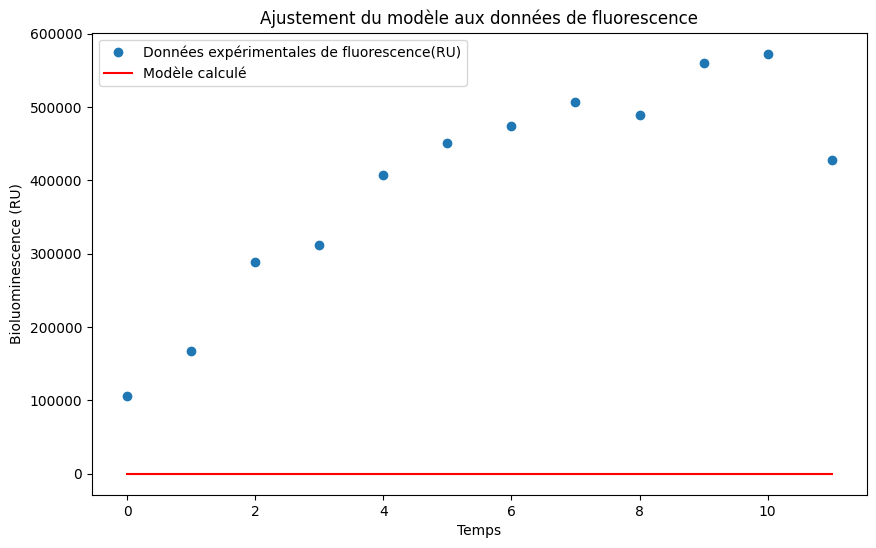

In [19]:
plt.figure(figsize=(10,6))
plt.plot(t,dt6, 'o', label='Données expérimentales de fluorescence(RU)')
plt.plot(t, fitted_ru, 'r', label='Modèle calculé')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Bioluominescence (RU)')
plt.title('Ajustement du modèle aux données de fluorescence')
plt.show()

#### Affichage des résultats

In [17]:
for name, param in result.params.items():
    value = param.value

    print(f"{name}: {value:.4e}")

alpha: 0.0000e+00
beta: 0.0000e+00
kon: 9.9141e+06
koff: 3.2445e-01
A0: 4.6958e-05
B0: 3.4232e-05
